In [3]:
import os
import numpy as np
import torch
from tqdm import tqdm
from nilearn import datasets, plotting
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from torchvision import models, transforms
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import IncrementalPCA
from scipy.stats import pearsonr as corr


In [4]:
data_dir = './algonauts_2023_challenge_data'
parent_submission_dir = './algonauts_2023_challenge_submission'
device = 'cpu'
#device = 'mps'
device = torch.device(device)

# Data loading and storage, taken from the tutorial 

In [5]:

class argObj:
  def __init__(self, data_dir, parent_submission_dir, subj):

    self.subj = format(subj, '02')
    self.data_dir = os.path.join(data_dir, 'subj'+self.subj)
    self.parent_submission_dir = parent_submission_dir
    self.subject_submission_dir = os.path.join(self.parent_submission_dir,
        'subj'+self.subj)

    # Create the submission directory if not existing
    if not os.path.isdir(self.subject_submission_dir):
        os.makedirs(self.subject_submission_dir)


In [6]:
class argObj:
  def __init__(self, data_dir, parent_submission_dir, subj):

    self.subj = format(subj, '02')
    self.data_dir = os.path.join(data_dir, 'subj'+self.subj)
    self.parent_submission_dir = parent_submission_dir
    self.subject_submission_dir = os.path.join(self.parent_submission_dir,
        'subj'+self.subj)

    # Create the submission directory if not existing
    if not os.path.isdir(self.subject_submission_dir):
        os.makedirs(self.subject_submission_dir)

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img

/Users/oomily/anaconda3/envs/algonauts/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/oomily/anaconda3/envs/algonauts/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training stimulus images: 7265

Validation stimulus images: 1817
(7265, 18978)
(7265, 20220)
(1817, 18978)
(1817, 20220)
['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.relu_1', 'layer1.0.conv3', 'layer1.0.bn3', 'layer1.0.downsample.0', 'layer1.0.downsample.1', 'layer1.0.add', 'layer1.0.relu_2', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.relu_1', 'layer1.1.conv3', 'layer1.1.bn3', 'layer1.1.add', 'layer1.1.relu_2', 'layer1.2.conv1', 'layer1.2.bn1', 'layer1.2.relu', 'layer1.2.conv2', 'layer1.2.bn2', 'layer1.2.relu_1', 'layer1.2.conv3', 'layer1.2.bn3', 'layer1.2.add', 'layer1.2.relu_2', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.relu_1', 'layer2.0.conv3', 'layer2.0.bn3', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_2', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.re

100%|██████████| 2/2 [00:34<00:00, 17.27s/it]



Training images features:
(7265, 100)
(Training stimulus images × PCA features)

Validation images features:
(1817, 100)
(Validation stimulus images × PCA features)

Test images features:
(1817, 100)
(Test stimulus images × PCA features)


100%|██████████| 20220/20220 [00:05<00:00, 3401.60it/s]



Dataset created in /Users/oomily/nilearn_data/fsaverage



Downloaded 27172864 of 34242788 bytes (79.4%,    0.5s remaining) ...done. (5 seconds, 0 min)
Extracting data from /Users/oomily/nilearn_data/fsaverage/735bf0f211246c83396b5f21f706c224/download..... done.
/Users/oomily/anaconda3/envs/algonauts/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/oomily/anaconda3/envs/algonauts/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/oomily/anaconda3/envs/algonauts/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/oomily/anaconda3/envs/algonauts/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'wei

Training stimulus images: 7872

Validation stimulus images: 1969
(7872, 19004)
(7872, 20544)
(1969, 19004)
(1969, 20544)
['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.relu_1', 'layer1.0.conv3', 'layer1.0.bn3', 'layer1.0.downsample.0', 'layer1.0.downsample.1', 'layer1.0.add', 'layer1.0.relu_2', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.relu_1', 'layer1.1.conv3', 'layer1.1.bn3', 'layer1.1.add', 'layer1.1.relu_2', 'layer1.2.conv1', 'layer1.2.bn1', 'layer1.2.relu', 'layer1.2.conv2', 'layer1.2.bn2', 'layer1.2.relu_1', 'layer1.2.conv3', 'layer1.2.bn3', 'layer1.2.add', 'layer1.2.relu_2', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.relu_1', 'layer2.0.conv3', 'layer2.0.bn3', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_2', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.re

100%|██████████| 2/2 [00:16<00:00,  8.07s/it]



Training images features:
(7872, 100)
(Training stimulus images × PCA features)

Validation images features:
(1969, 100)
(Validation stimulus images × PCA features)

Test images features:
(1969, 100)
(Test stimulus images × PCA features)


100%|██████████| 20544/20544 [00:06<00:00, 3318.71it/s]
/Users/oomily/anaconda3/envs/algonauts/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/oomily/anaconda3/envs/algonauts/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/oomily/anaconda3/envs/algonauts/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/oomily/anaconda3/envs/algonauts/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K

Training stimulus images: 7023

Validation stimulus images: 1756
(7023, 18981)
(7023, 20530)
(1756, 18981)
(1756, 20530)
['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.relu_1', 'layer1.0.conv3', 'layer1.0.bn3', 'layer1.0.downsample.0', 'layer1.0.downsample.1', 'layer1.0.add', 'layer1.0.relu_2', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.relu_1', 'layer1.1.conv3', 'layer1.1.bn3', 'layer1.1.add', 'layer1.1.relu_2', 'layer1.2.conv1', 'layer1.2.bn1', 'layer1.2.relu', 'layer1.2.conv2', 'layer1.2.bn2', 'layer1.2.relu_1', 'layer1.2.conv3', 'layer1.2.bn3', 'layer1.2.add', 'layer1.2.relu_2', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.relu_1', 'layer2.0.conv3', 'layer2.0.bn3', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_2', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.re

100%|██████████| 3/3 [00:45<00:00, 15.03s/it]



Training images features:
(7023, 100)
(Training stimulus images × PCA features)

Validation images features:
(1756, 100)
(Validation stimulus images × PCA features)

Test images features:
(1756, 100)
(Test stimulus images × PCA features)


100%|██████████| 20530/20530 [00:06<00:00, 3418.78it/s]
/Users/oomily/anaconda3/envs/algonauts/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/oomily/anaconda3/envs/algonauts/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


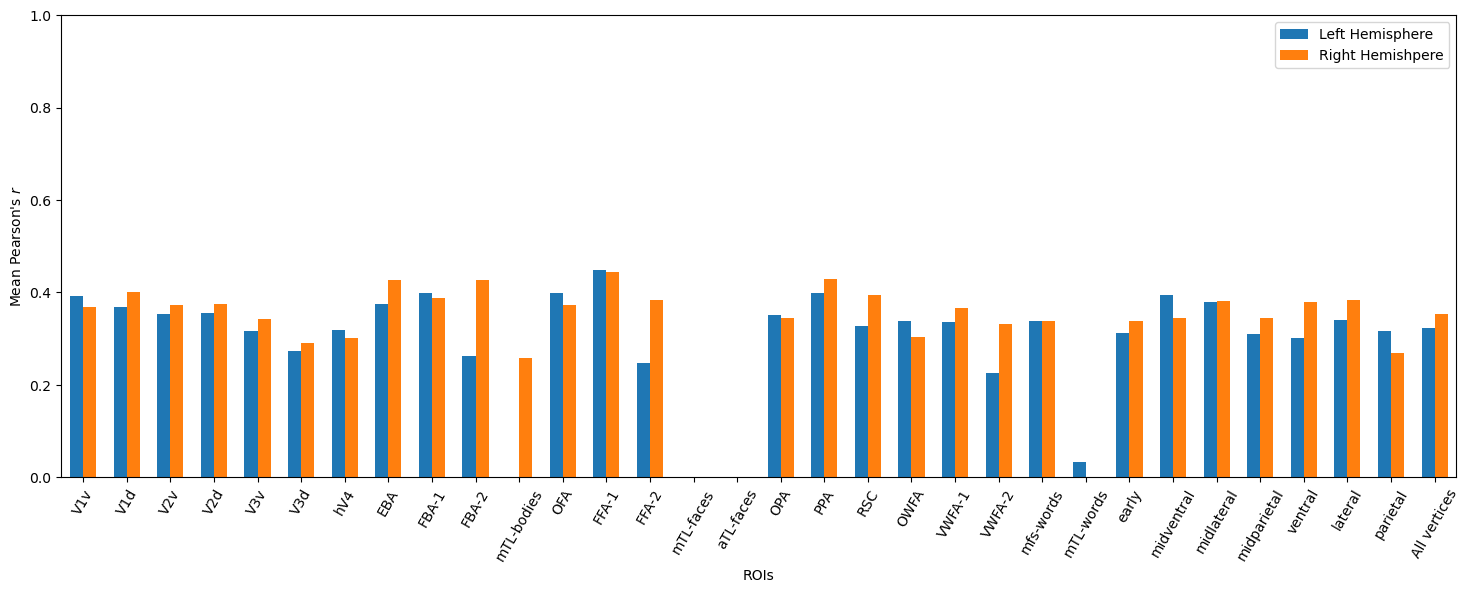

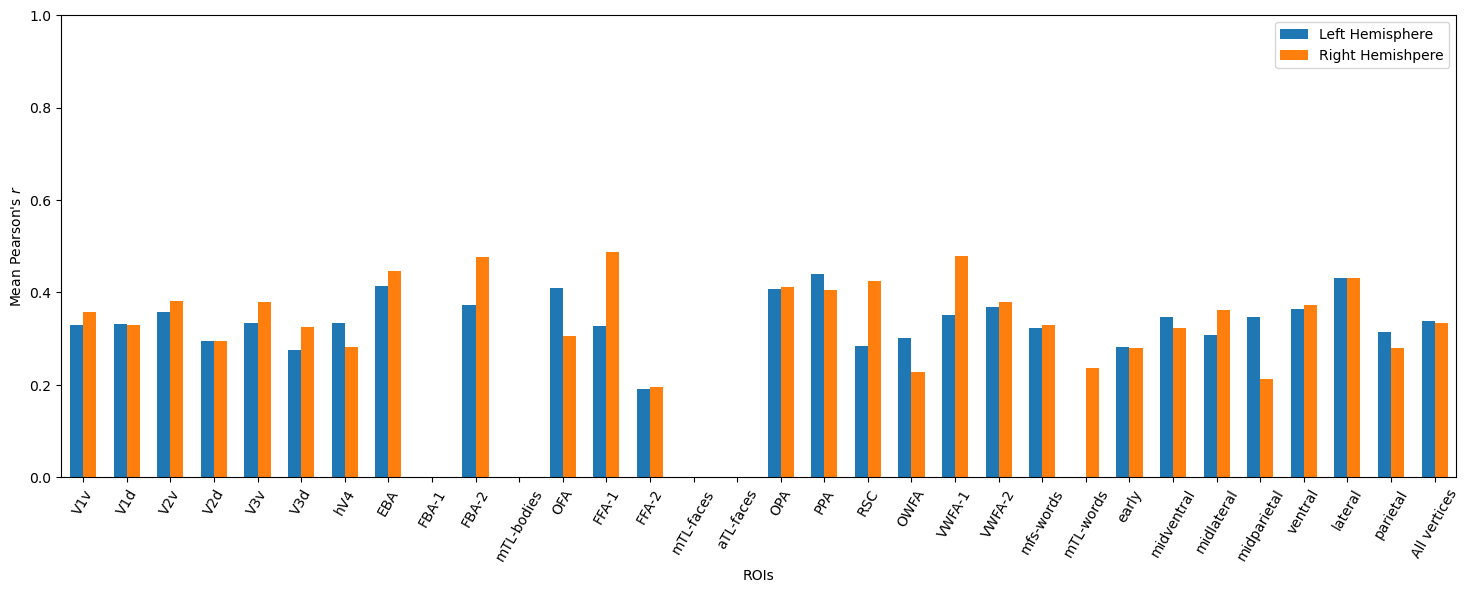

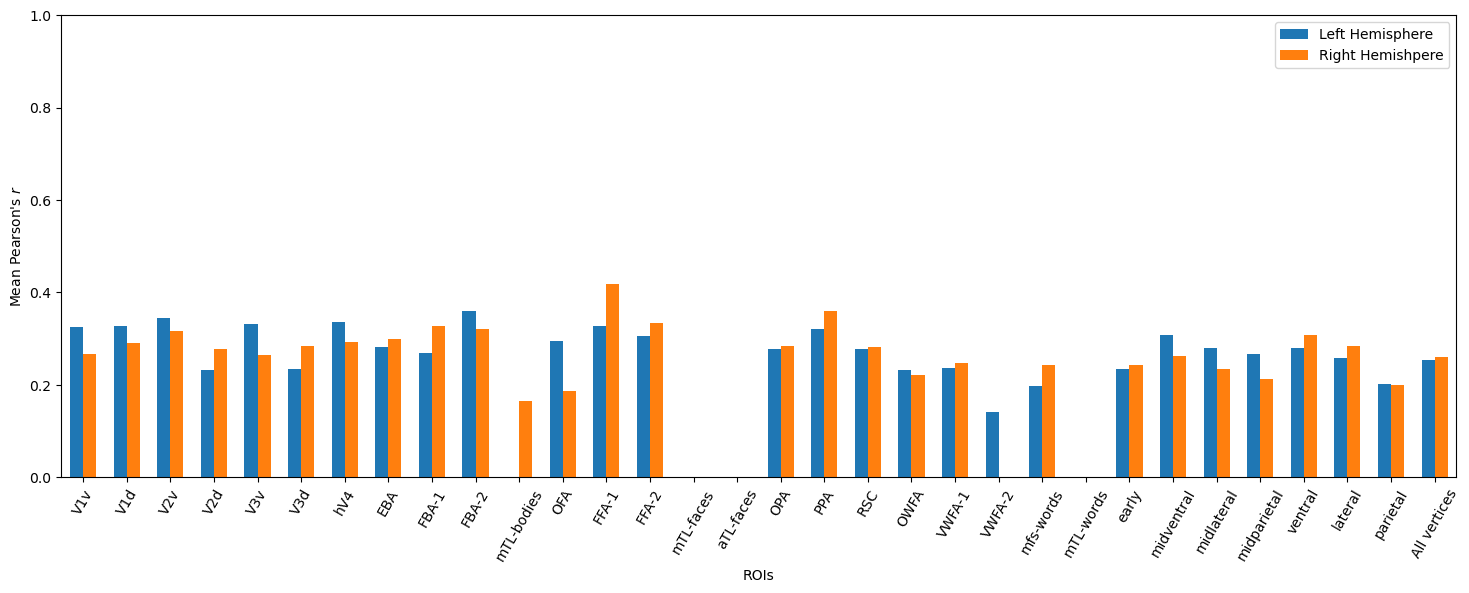

In [7]:
batch_size = 150
for i in range(6, 9):
    resnet50 = models.resnet50(pretrained=True)
    resnet50.eval()
    resnet50.to(device)
    args = argObj(data_dir, parent_submission_dir, i)
    fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
    lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
    rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

    train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
    test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')
    train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
    test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

    train_img_list = os.listdir(train_img_dir)
    train_img_list.sort()
    test_img_list = os.listdir(test_img_dir)
    test_img_list.sort()

    idxs_train = np.arange(len(train_img_list))
    idxs_train,idxs_val,x,x= train_test_split(idxs_train, idxs_train,test_size=0.2)
    idxs_test = np.arange(len(test_img_list))

    print('Training stimulus images: ' + format(len(idxs_train)))
    print('\nValidation stimulus images: ' + format(len(idxs_val)))

        # The DataLoaders contain the ImageDataset class
    train_imgs_dataloader = DataLoader(
        ImageDataset(train_imgs_paths, idxs_train, preprocess),
        batch_size=batch_size
    )
    val_imgs_dataloader = DataLoader(
        ImageDataset(train_imgs_paths, idxs_val, preprocess),
        batch_size=batch_size
    )
    test_imgs_dataloader = DataLoader(
        ImageDataset(test_imgs_paths, idxs_test, preprocess),
        batch_size=batch_size
    )

    lh_fmri_train = lh_fmri[idxs_train]
    lh_fmri_val = lh_fmri[idxs_val]
    rh_fmri_train = rh_fmri[idxs_train]
    rh_fmri_val = rh_fmri[idxs_val]

    print(lh_fmri_train.shape)
    print(rh_fmri_train.shape)
    print(lh_fmri_val.shape)
    print(rh_fmri_val.shape)

    del lh_fmri, rh_fmri


    train_nodes, _ = get_graph_node_names(resnet50)
    print(train_nodes)

    model_layer = 'layer4.2.relu_2'
    feature_extractor = create_feature_extractor(resnet50, return_nodes=[model_layer])
    def fit_pca(feature_extractor, dataloader):

        # Define PCA parameters
        n_components = 100
        pca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

        # Fit PCA to batch
        for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
            # Extract features
            ft = feature_extractor(d)
            # Flatten the features
            ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
            # Fit PCA to batch
            if len(ft) >= n_components: #makes sure that n_components <= number of items in batch
              pca.partial_fit(ft.detach().cpu().numpy())
        return pca

    pca = fit_pca(feature_extractor, train_imgs_dataloader)

    def extract_features(feature_extractor, dataloader, pca):

        features = []
        for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
            # Extract features
            ft = feature_extractor(d)
            # Flatten the features
            ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
            # Apply PCA transform
            ft = pca.transform(ft.cpu().detach().numpy())
            features.append(ft)
        return np.vstack(features)

    features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
    features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)
    features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

    print('\nTraining images features:')
    print(features_train.shape)
    print('(Training stimulus images × PCA features)')

    print('\nValidation images features:')
    print(features_val.shape)
    print('(Validation stimulus images × PCA features)')

    print('\nTest images features:')
    print(features_val.shape)
    print('(Test stimulus images × PCA features)')

    del resnet50, pca

    # Fit linear regressions on the training data
    reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
    reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
    # Use fitted linear regressions to predict the validation and test fMRI data
    lh_fmri_val_pred = reg_lh.predict(features_val)
    lh_fmri_test_pred = reg_lh.predict(features_test)
    rh_fmri_val_pred = reg_rh.predict(features_val)
    rh_fmri_test_pred = reg_rh.predict(features_test)

    # Empty correlation array of shape: (LH vertices)
    lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
    # Correlate each predicted LH vertex with the corresponding ground truth vertex
    for v in tqdm(range(lh_fmri_val_pred.shape[1])):
        lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

    # Empty correlation array of shape: (RH vertices)
    rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
    # Correlate each predicted RH vertex with the corresponding ground truth vertex
    for v in tqdm(range(rh_fmri_val_pred.shape[1])):
        rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]

    hemisphere = 'left'

    # Load the brain surface map of all vertices
    roi_dir = os.path.join(args.data_dir, 'roi_masks',
        hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
    fsaverage_all_vertices = np.load(roi_dir)

    # Map the correlation results onto the brain surface map
    fsaverage_correlation = np.zeros(len(fsaverage_all_vertices))
    if hemisphere == 'left':
        fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = lh_correlation
    elif hemisphere == 'right':
        fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = rh_correlation

    # Create the interactive brain surface map
    fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
    view = plotting.view_surf(
        surf_mesh=fsaverage['infl_'+hemisphere],
        surf_map=fsaverage_correlation,
        bg_map=fsaverage['sulc_'+hemisphere],
        threshold=1e-14,
        cmap='cold_hot',
        colorbar=True,
        title='Encoding accuracy, '+hemisphere+' hemisphere'
        )
    view

    # Load the ROI classes mapping dictionaries
    roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
        'mapping_floc-faces.npy', 'mapping_floc-places.npy',
        'mapping_floc-words.npy', 'mapping_streams.npy']
    roi_name_maps = []
    for r in roi_mapping_files:
        roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
            allow_pickle=True).item())

    # Load the ROI brain surface maps
    lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
        'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
        'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
        'lh.streams_challenge_space.npy']
    rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
        'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
        'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
        'rh.streams_challenge_space.npy']
    lh_challenge_rois = []
    rh_challenge_rois = []
    for r in range(len(lh_challenge_roi_files)):
        lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
            lh_challenge_roi_files[r])))
        rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
            rh_challenge_roi_files[r])))

    # Select the correlation results vertices of each ROI
    roi_names = []
    lh_roi_correlation = []
    rh_roi_correlation = []
    for r1 in range(len(lh_challenge_rois)):
        for r2 in roi_name_maps[r1].items():
            if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
                roi_names.append(r2[1])
                lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
                rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
                lh_roi_correlation.append(lh_correlation[lh_roi_idx])
                rh_roi_correlation.append(rh_correlation[rh_roi_idx])
    roi_names.append('All vertices')
    lh_roi_correlation.append(lh_correlation)
    rh_roi_correlation.append(rh_correlation)

    # Create the plot
    lh_mean_roi_correlation = [np.mean(lh_roi_correlation[r])
        for r in range(len(lh_roi_correlation))]
    rh_mean_roi_correlation = [np.mean(rh_roi_correlation[r])
        for r in range(len(rh_roi_correlation))]
    plt.figure(figsize=(18,6))
    x = np.arange(len(roi_names))
    width = 0.30
    plt.bar(x - width/2, lh_mean_roi_correlation, width, label='Left Hemisphere')
    plt.bar(x + width/2, rh_mean_roi_correlation, width,
        label='Right Hemishpere')
    plt.xlim(left=min(x)-.5, right=max(x)+.5)
    plt.ylim(bottom=0, top=1)
    plt.xlabel('ROIs')
    plt.xticks(ticks=x, labels=roi_names, rotation=60)
    plt.ylabel('Mean Pearson\'s $r$')
    plt.legend(frameon=True, loc=1);
    lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
    rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)
    np.save(os.path.join(args.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
    np.save(os.path.join(args.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)